In [1]:
include("EdwardsAndersonModel.jl")
using .EdwardsAndersonModel
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, Random, ProgressMeter
using CairoMakie

seed = 42
Random.seed!(seed)

init_logger(dir="../../logs", level=:Info)
println(names(EdwardsAndersonModel))

[:EdwardsAndersonModel, :calc_energy, :calc_gradient, :calc_gradient_no_constraints, :calc_round_trip_times, :initial_state, :metropolis_sampler]


In [ ]:
N = 8
β_min = 0.1
β_max = 1.5
M = 20
η = 0.005
mcSteps = 2*10^4
eqSteps = 10^2
# target = 0.23
epochs = 300
batch_size = 10
Jh = randn(N, N, N)
Jv = randn(N, N, N)
Jz = randn(N, N, N)

@info """
Hyperparameters of Gaussian model:
--------------------
system size: $(N*N*N),
the number of replica: $M,
MCS: $mcSteps
Jh: $Jh,
Jv: $Jv,
Jz: $Jz
"""
println("Set hyperparameters.")

Set hyperparameters.


In [8]:
init_β_set = Utils.set_temperatures(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
init_logΔβ = β2logD(init_β_set)
_, exchange_prob_means = EdwardsAndersonModel.calc_gradient(N, init_β_set, Jh, Jv, Jz)

println(init_β_set)
println(init_logΔβ)
# println(D2β(init_Δβ, β_min))
println(logD2β(init_logΔβ[1:M-2], β_min, β_max))
println(exchange_prob_means)

[0.1, 0.11531864743932996, 0.13298390447236477, 0.1533552399495417, 0.17684718848715042, 0.20393778579786437, 0.23517829619981506, 0.27120443024848784, 0.31274928075809716, 0.36065824044647027, 0.415906204761356, 0.4796174099470457, 0.5530883100344796, 0.6378139582768096, 0.735518429864069, 0.8481899049862411, 0.9781211261470709, 1.1279560529911445, 1.3007436640194396, 1.5]
[-4.178684405817243, -4.036155447864497, -3.8936264899117465, -3.751097531959002, -3.6085685740062496, -3.466039616053506, -3.3235106581007563, -3.1809817001480094, -3.0384527421952603, -2.895923784242512, -2.753394826289766, -2.6108658683370156, -2.4683369103842687, -2.3258079524315223, -2.1832789944787727, -2.0407500365260267, -1.898221078573277, -1.7556921206205296, -1.613163162667782]
[0.1, 0.11531864743932996, 0.13298390447236477, 0.1533552399495417, 0.17684718848715042, 0.20393778579786437, 0.23517829619981506, 0.27120443024848784, 0.31274928075809716, 0.36065824044647027, 0.415906204761356, 0.4796174099470457

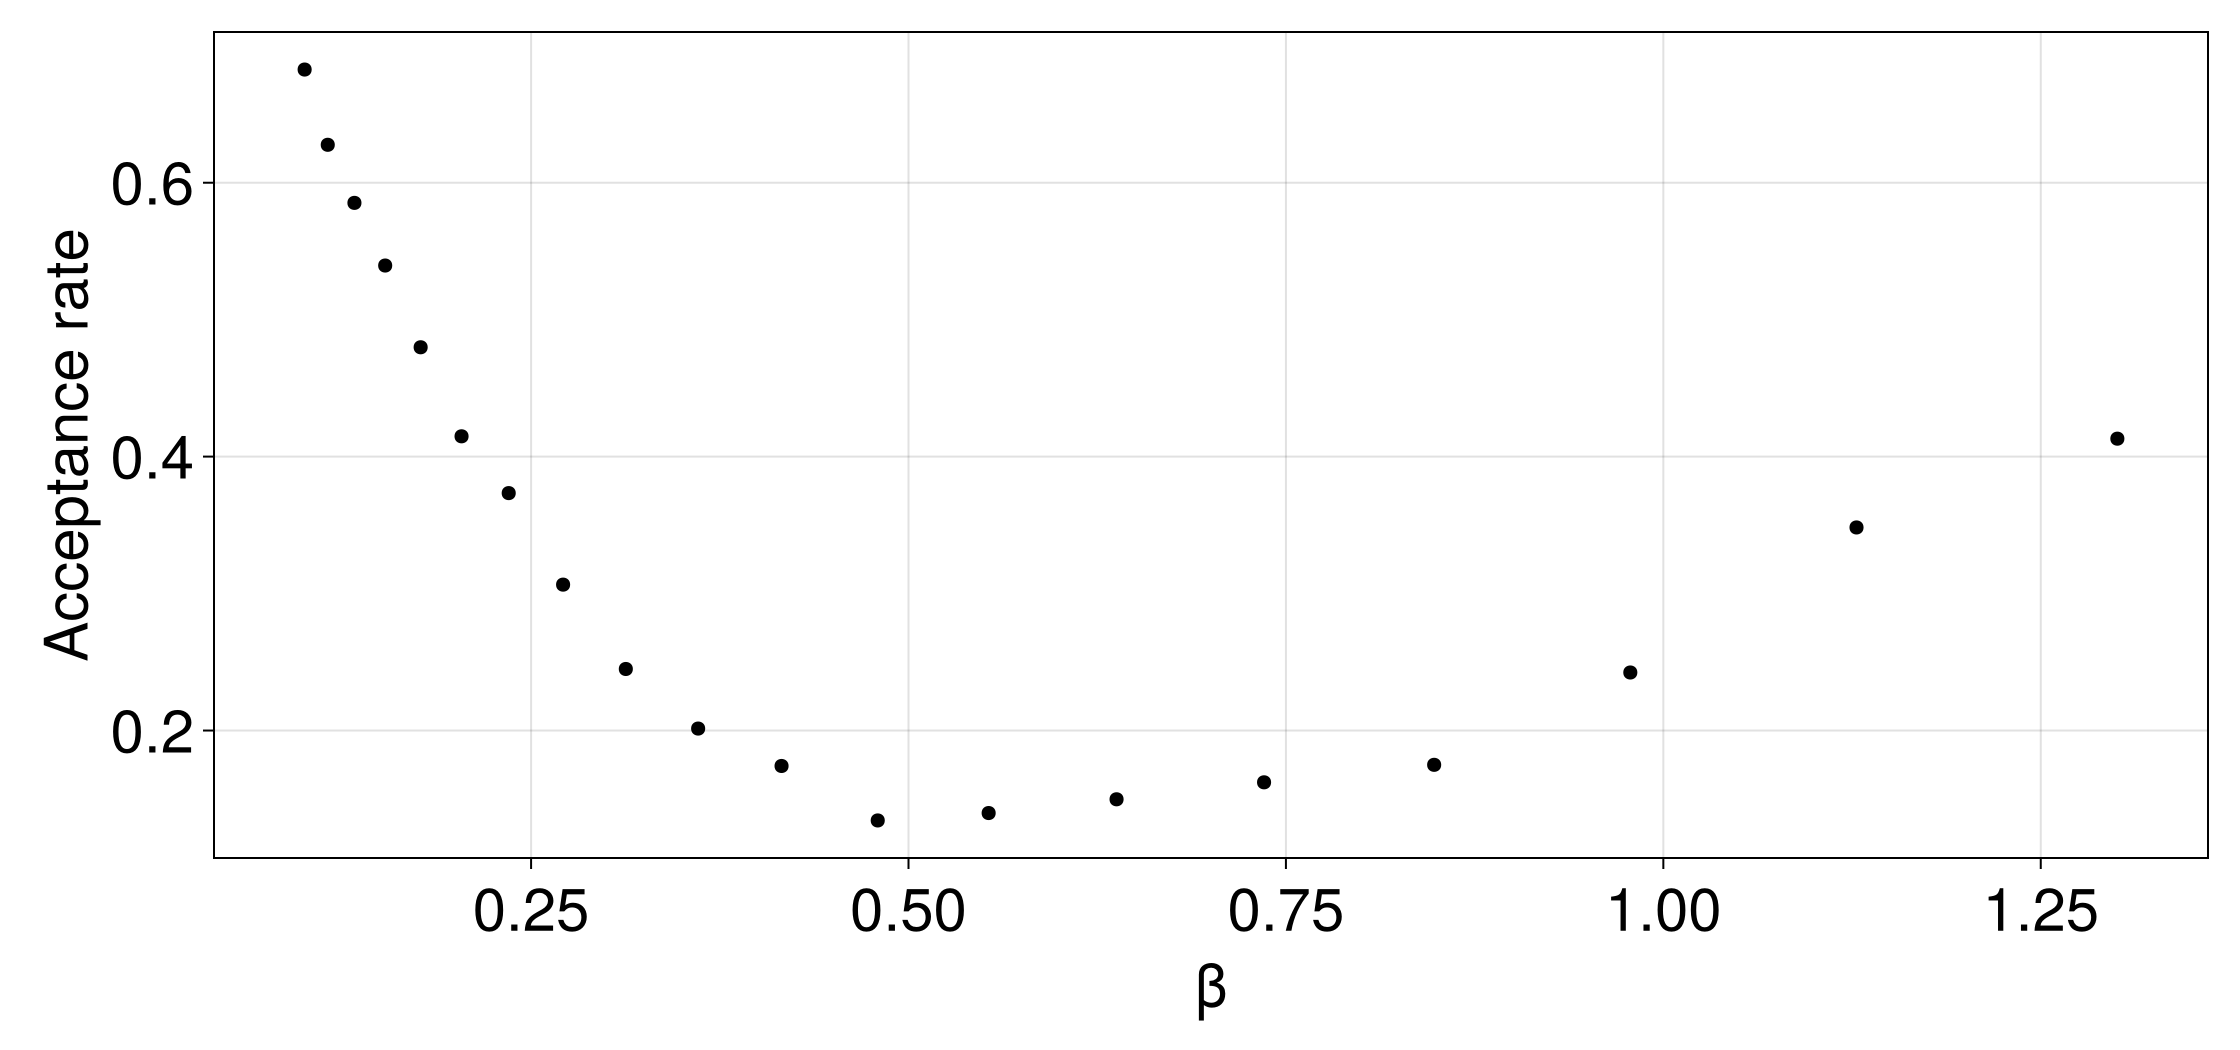

CairoMakie.Screen{IMAGE}


In [9]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
scatter!(ax1, init_β_set[1:(end-1)], exchange_prob_means, color=:black, markersize=10)

display(fig1)

In [ ]:
β_set = deepcopy(init_β_set)
β_set_trace = [β_set]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β2logD(β_set)[1:M-2])

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = EdwardsAndersonModel.calc_gradient(
            N, 
            β_set,
            Jh,
            Jv,
            Jz;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    
    logΔβ = β2logD(β_set)[1:M-2]
    setup, logΔβ = Optimisers.update(setup, logΔβ, grad_mean)
    β_set = logD2β(logΔβ, β_min, β_max)

    push!(β_set_trace, deepcopy(β_set))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5))±$(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 11:47:35


In [6]:
dir = "../../plots/EA_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/EA_model/L=8/M=20"

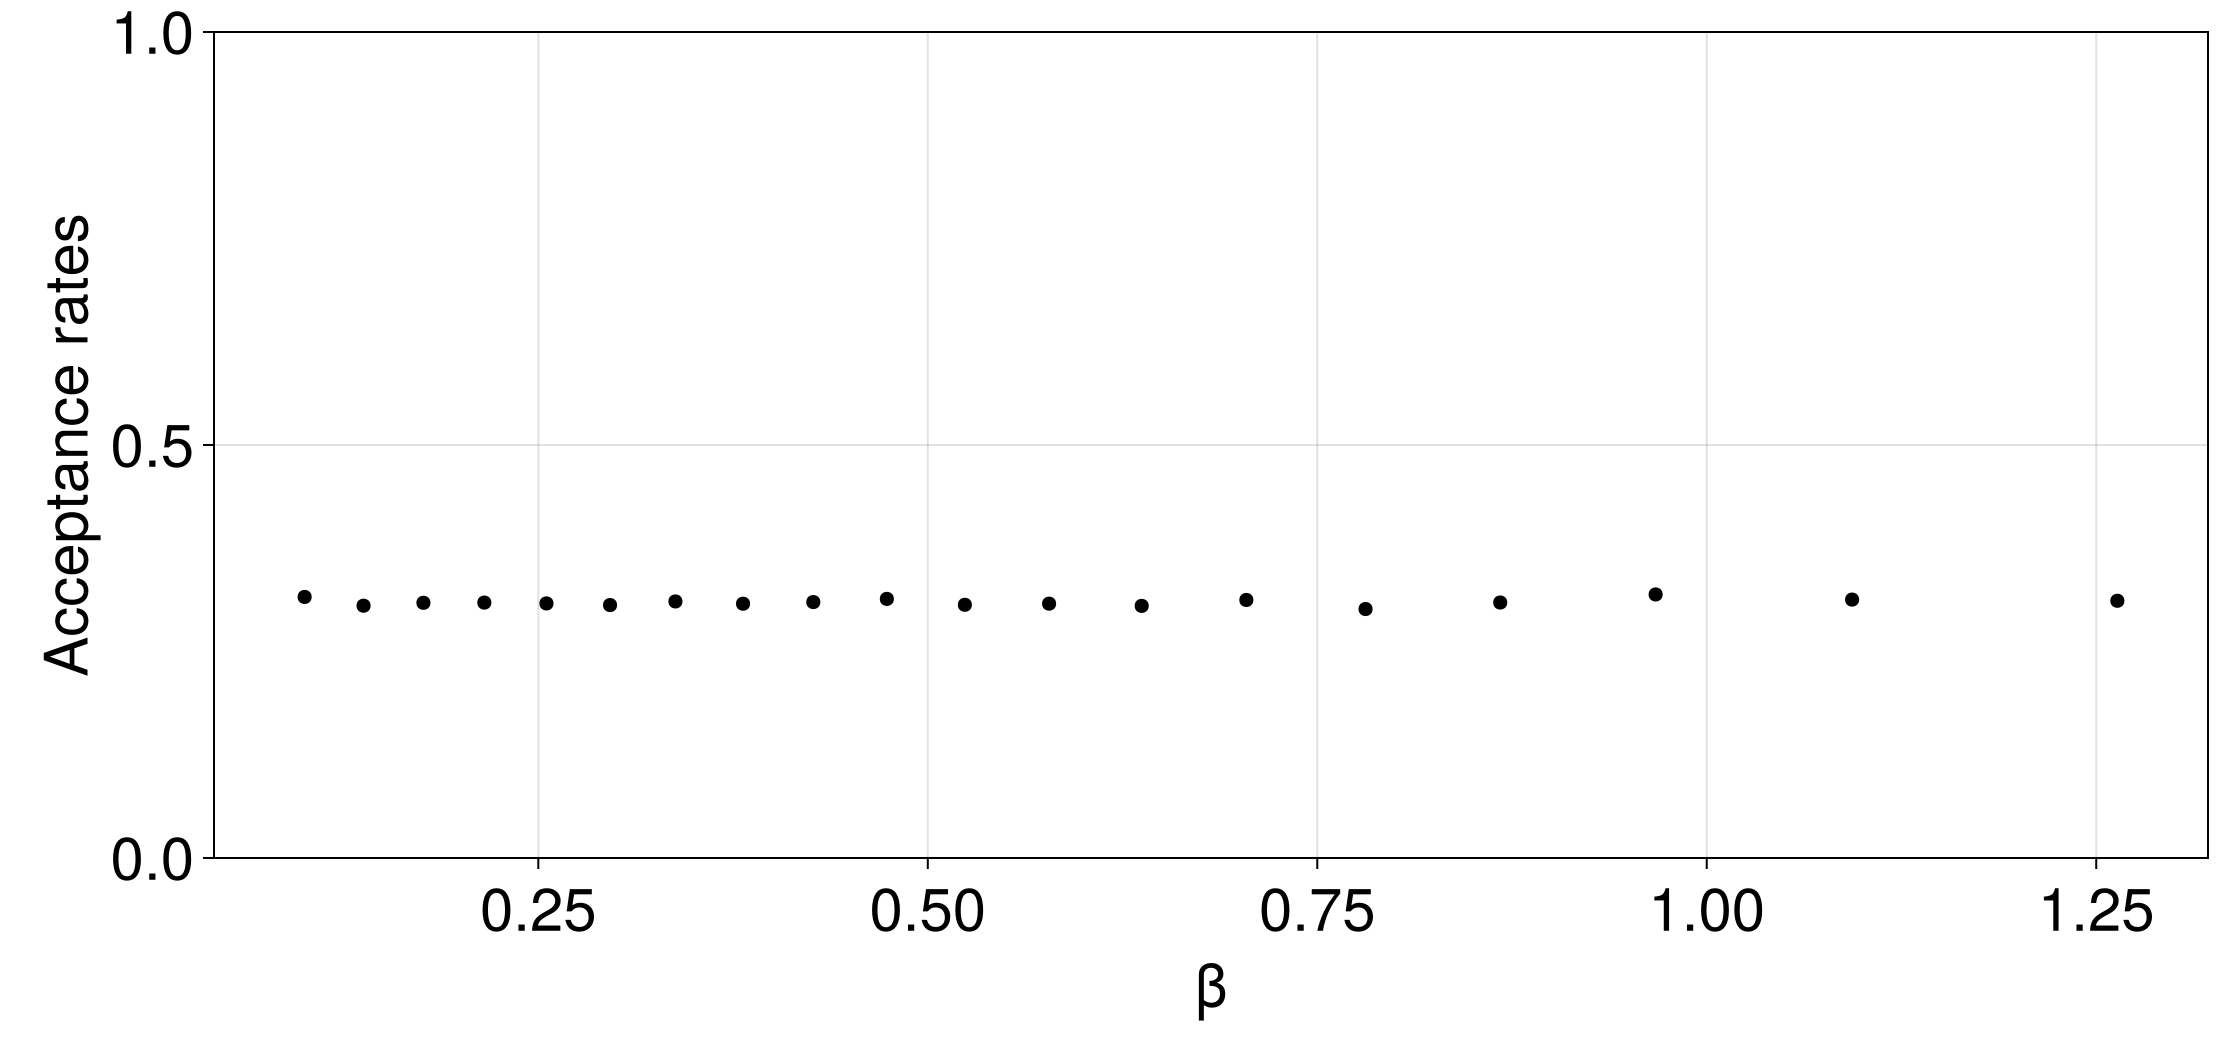

CairoMakie.Screen{IMAGE}


In [ ]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rates")
ylims!(ax1, 0, 1)
scatter!(ax1, β_set_trace[end][1:(end-1)], exchange_prob_trace[end], color=:black, markersize=10)

display(fig1)

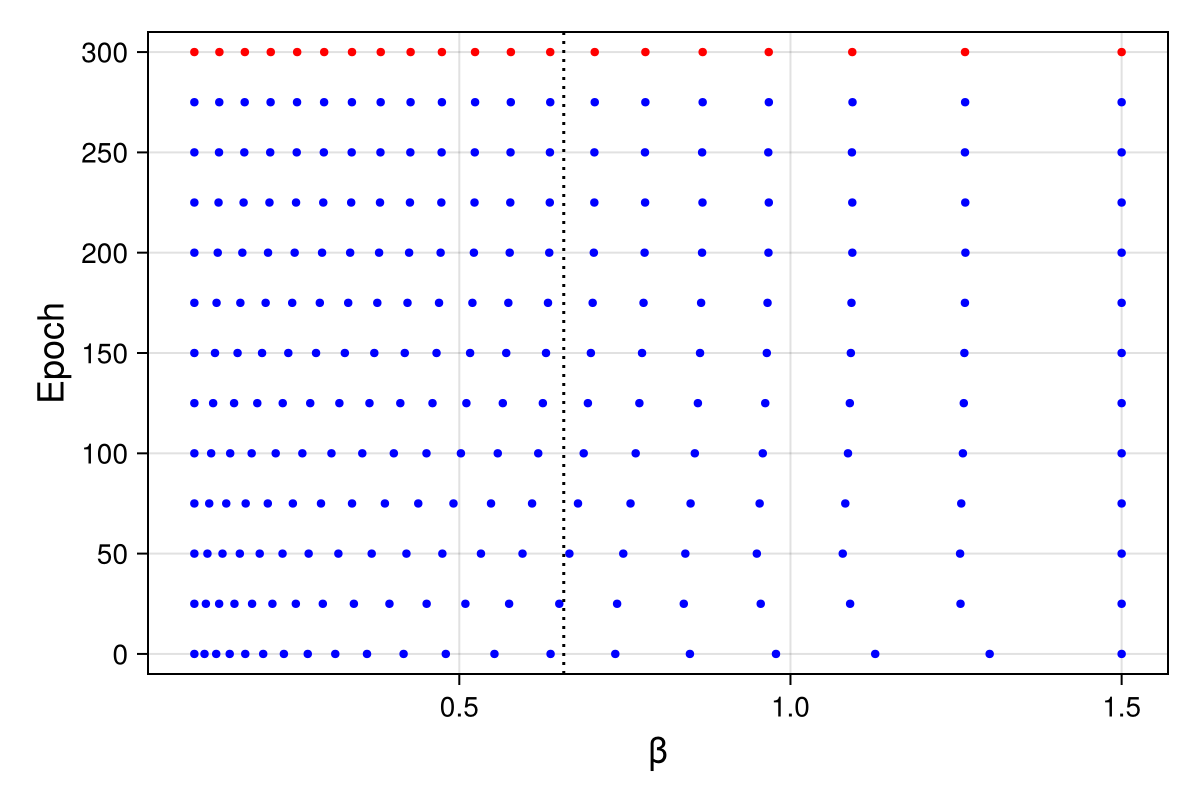

In [ ]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "Epoch",
    xlabelsize = 18,
    ylabelsize = 18, 
    yticks = 0:50:epochs
)
# xlims!(ax, -0.05, 2.05)
ylims!(ax, -10, epochs+10)

plot_interval = 25
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_set
        y_values = fill(step, length(β_values))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
        # if step == 50
        #     plot_interval = 25
        # end
    end
end
# β_c = 1.05 # T_c=0.951
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
# text!(
#     ax,
#     L"\beta_c \approx %$(round(β_c, digits=3))", 
#     position = (β_c, -10), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )

β_dash = 0.6577177177177177
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")
display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

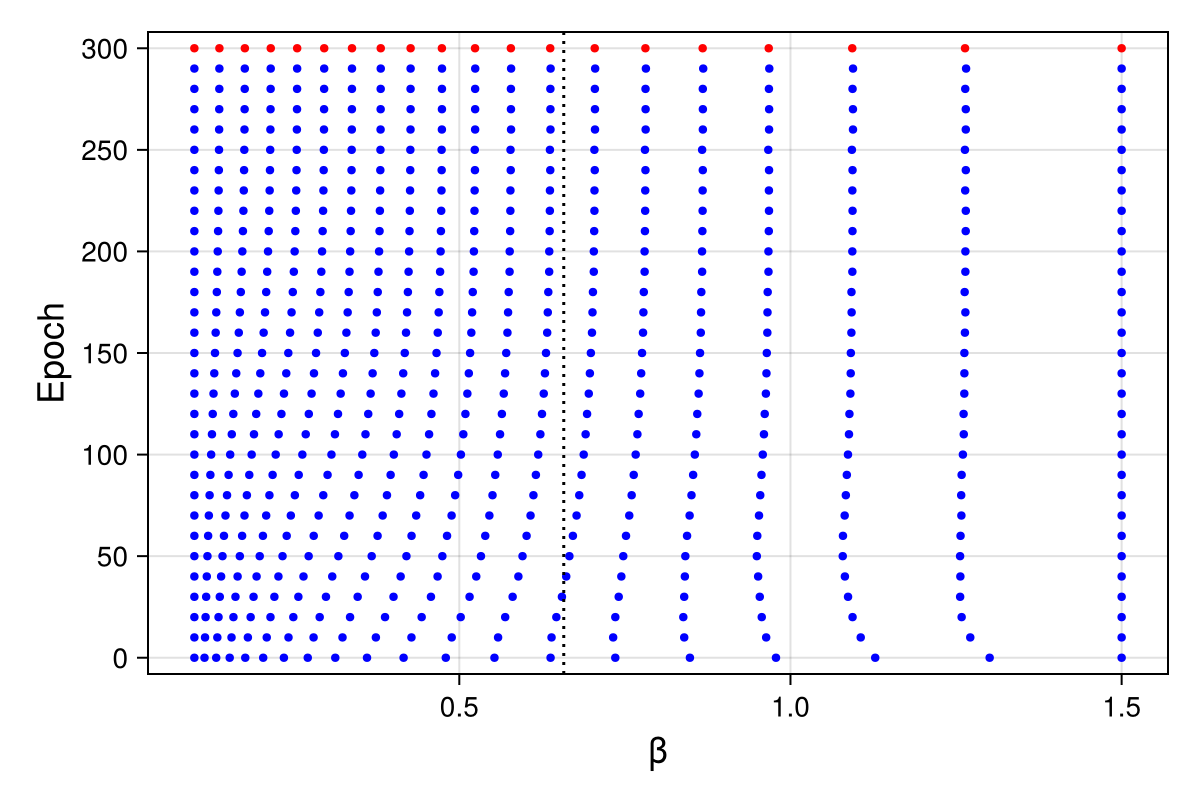

In [ ]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "Epoch",
    xlabelsize = 18,
    ylabelsize = 18, 
    yticks = 0:50:epochs
)
# xlims!(ax, -0.05, 2.05)
ylims!(ax, -8, epochs+8)

plot_interval = 10
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_set
        y_values = fill(step, length(β_values))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end

β_dash = 0.6577177177177177
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")
display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs every 10.png", fig; px_per_unit=4)

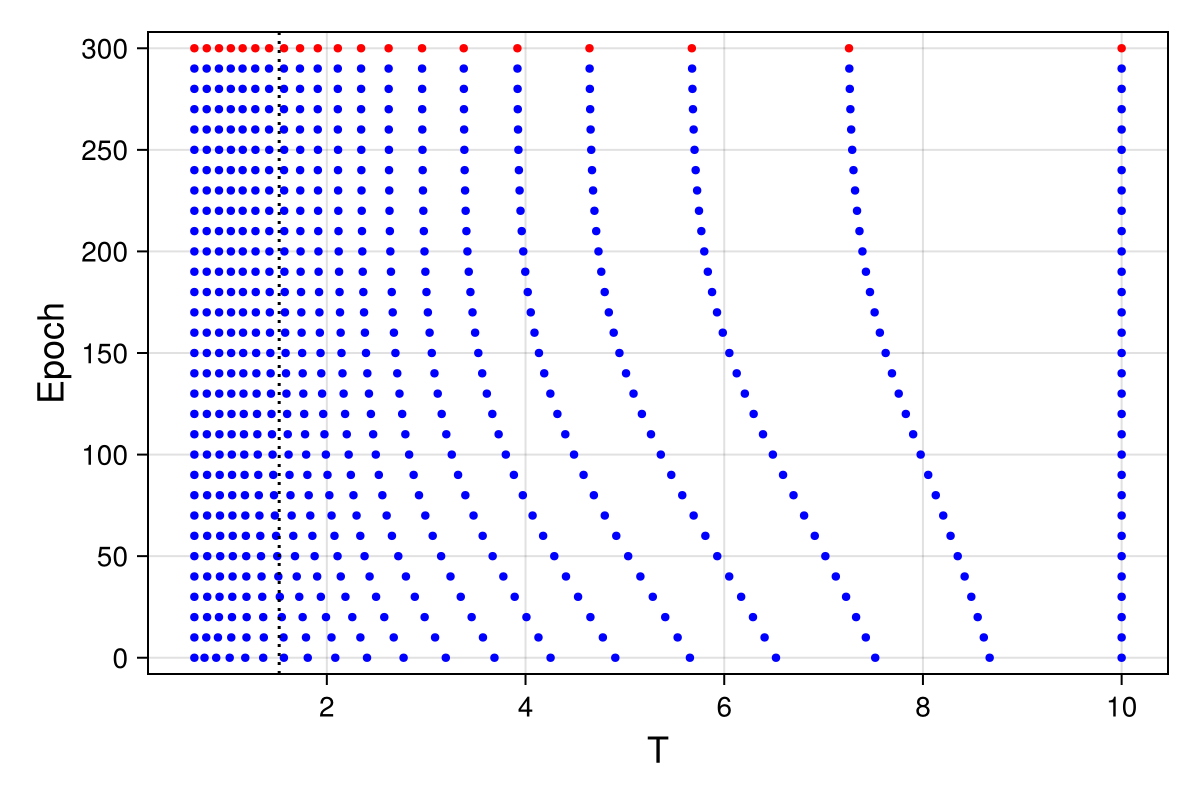

CairoMakie.Screen{IMAGE}


In [ ]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "T",
    ylabel = "Epoch", 
    xlabelsize = 18,
    ylabelsize = 18, 
    yticks = 0:50:epochs
)

ylims!(ax, -8, epochs+8)

plot_interval = 10
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        T_values = 1 ./ β_set
        y_values = fill(step, length(T_values))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, T_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
# T_c = 0.951
# vlines!(ax, [T_c], color=:black, linestyle=:dot, label="Critical Tc")
# text!(
#     ax,
#     L"T_c \approx %$(round(T_c, digits=3))", 
#     position = (T_c, -10), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )

T_dash = 1/0.6577177177177177
vlines!(ax, [T_dash], color=:black, linestyle=:dot, label="T at maximum specific heat")

display(fig)

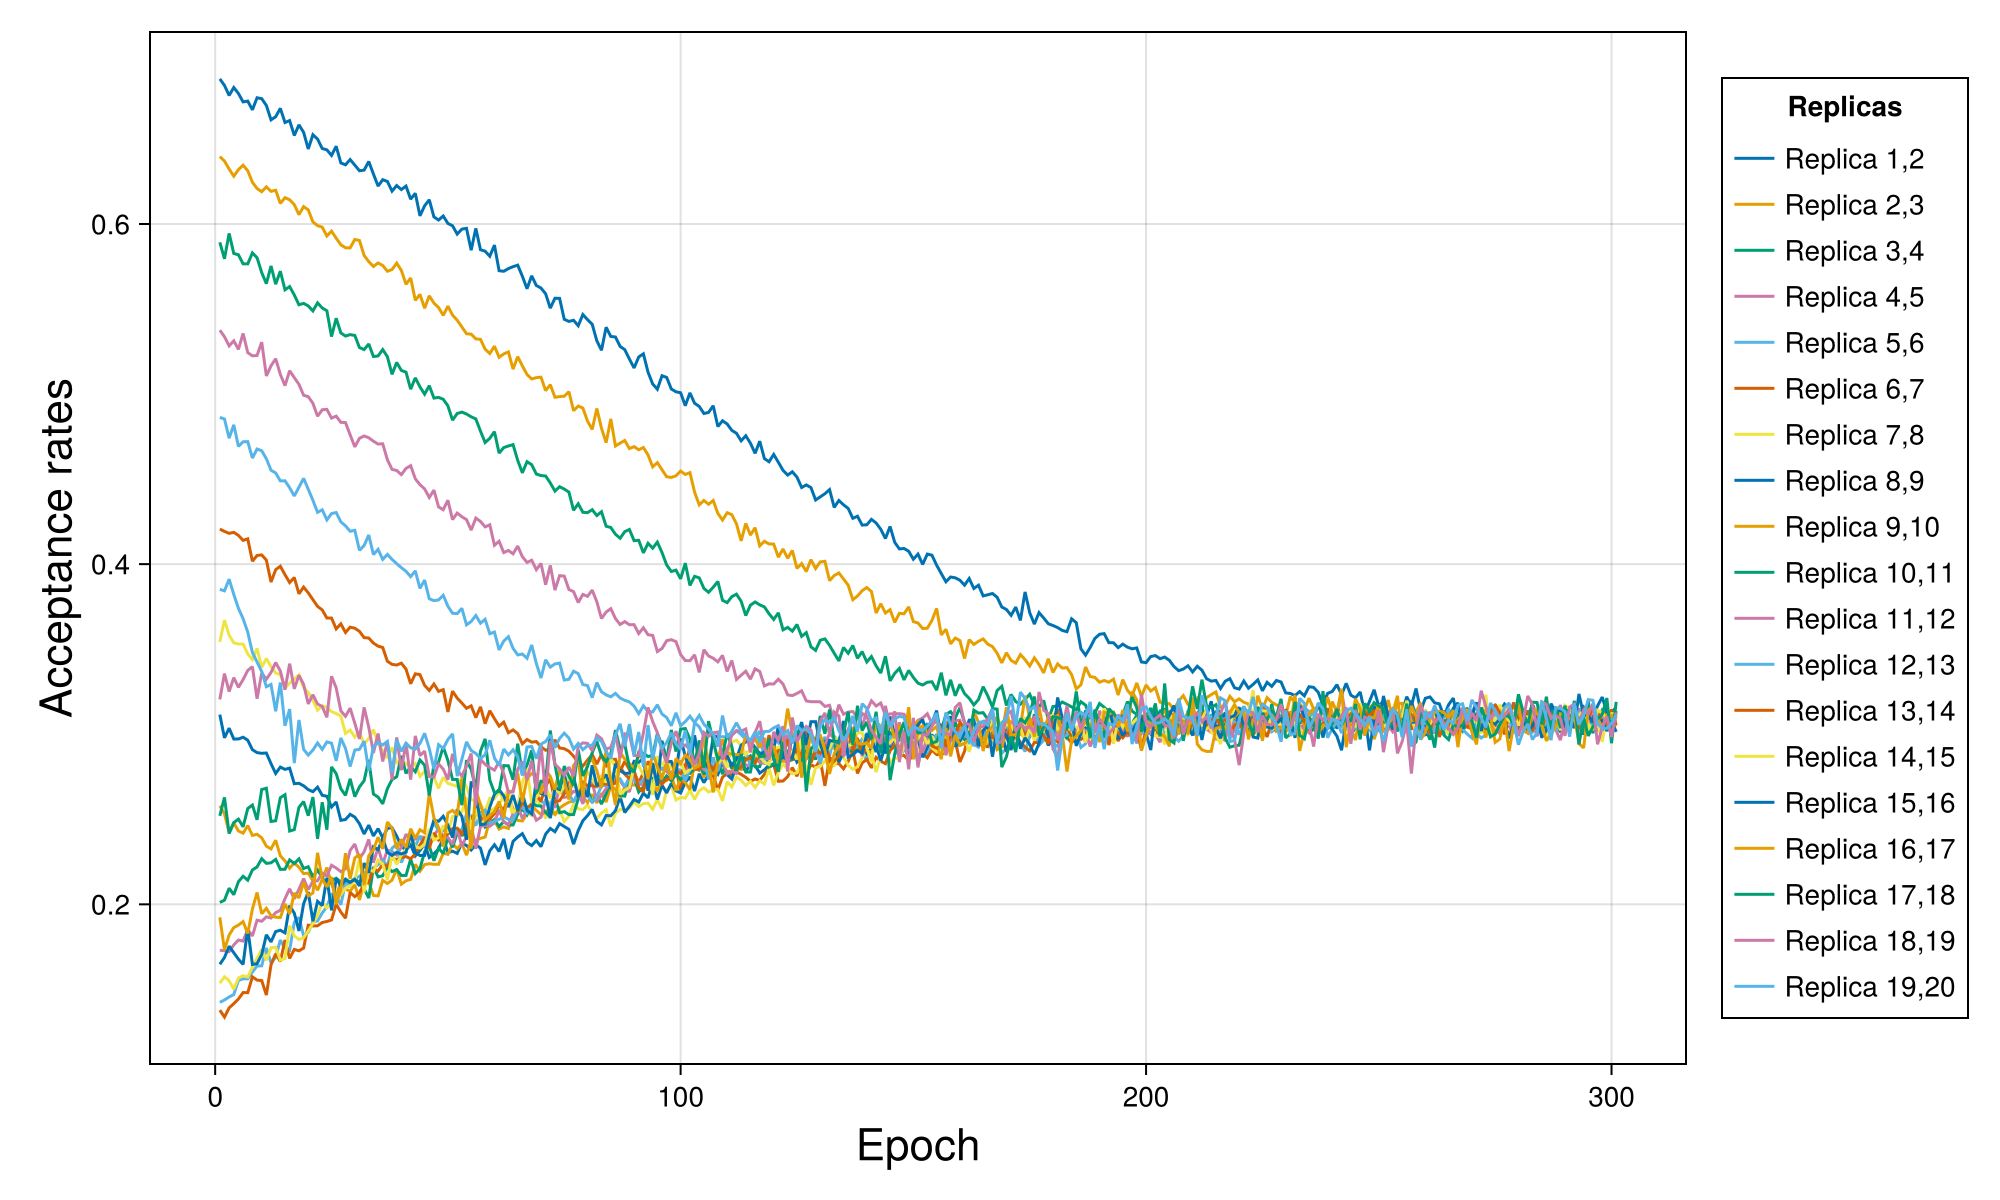

In [15]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size = (1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates", 
    xlabelsize = 22,
    ylabelsize = 22
)
# ylims!(ax2, 0, 1)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

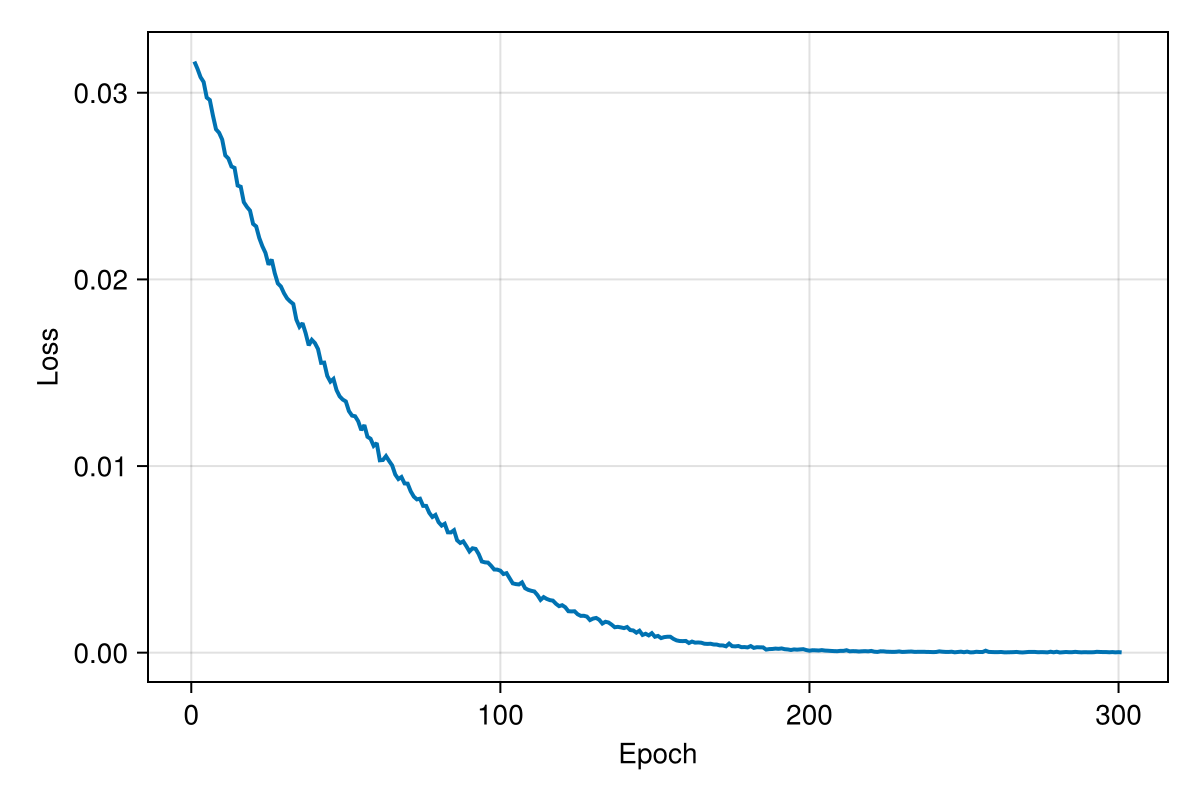

In [12]:
fig3 = Figure(size = (600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [ ]:
print(β_set_trace[end])

[0.1, 0.13781853593387333, 0.17624367641802136, 0.21534500200296336, 0.2552231568731468, 0.29604205334064576, 0.3380117332451736, 0.3814078975234144, 0.4265027257737936, 0.47372050588116354, 0.5237886551714492, 0.5778536186902201, 0.6373058074812217, 0.7044789566194224, 0.7809913661332339, 0.8674439394366827, 0.9671894148639452, 1.0932991364795863, 1.2635676300534342, 1.5]